<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Energy Consumption Forecasting using Vantage and SKLearn</b>
</header>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Introduction:</b></p>

<p style = 'font-size:16px;font-family:Arial'>For energy trading companies, forecasting of electricity consumption is one key driver in building a successful business. Proper forecasting of market demand prevents losses (in case of overselling energy to market) as well as lost profits (in case of underestimating of demand). Also, the regulator of the energy market can apply fees or even disqualify a trading company for certain time periods in case of frequent inaccurate forecasts. This is why increasing the accuracy even by 0.1% can significantly improve the profitability of the energy trading company.</p>

<p style = 'font-size:16px;font-family:Arial'>In this demo we demonstrate how the full lifecycle of consumption forecast can be implemented using Vantage technologies and specifically, the combination of Bring Your Own Model (BYOM), Vantage Analytics Library (VAL) and teradataml python client library solution. This demo consists of four parts (details on Teradata "Analytics 1-2-3" strategy can be found <a href = 'https://assets.teradata.com/resourceCenter/downloads/WhitePapers/Analytics-123-Enabling-Enterprise-AI-at-Scale-MD006623.pdf'>here</a>):</p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Data discovery using client python libraries</li>
    <li>Feature Prep and Transformation using Vantage Analytic Library</li>
    <li>Model training using the scikit-learn LinearRegression algorithm</li>
    <li>Scoring the model in Vantage and analyzing the results</li>
    </ol>

<p style = 'font-size:16px;font-family:Arial'>This datamart represents electricity consumption in Norway for the period from 1st of January 2016 to 31st of August 2019. Each line in this datamart reflects consumption for one hour. Apart of electricity consumption this datamart also reflects additional data: weather from multiple sources, daylight information and labor calendar. All data were collected from open data sources</p>

<br>

<b style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Utilize Vantage to Operationalize the Machine Learning Process</b>

<p style = 'font-size:16px;font-family:Arial'>Open-source tools and techniques provide a rich ecosystem for data scientists and analysts to gain new insights into their data.  However, the process of obtaining these insights is manual, error-prone, and time-consuming process.  Most machine learning tools and platforms seek to make model training more efficient, and ignore the more significant challenges with;</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Data Discovery and Statistical Analysis</li>
    <li>Data Preparation and Feature Engineering</li>
    <li>Model Deployment and Evaluation At Operational Scale</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial'>Traditional approaches require the developer to move data <b>from</b> the sources <b>to</b> the analytics.  Even "integrated" analytic systems like Apache Spark provide parallel processing for analyzing data, but don't optimize for loading data - neither locality nor quantity that needs to be moved.</p>



<p style = 'font-size:16px;font-family:Arial'>Teradata Vantage reverses this model; and provides the ability to PUSH processing down to the individual processing nodes where the data resides.  This allows for unprecedented scale of the analytical proccessing, reduced costs in data movement/egress charges, and drastically improved performance.</p> 

<p style = 'font-size:16px;font-family:Arial;color:#E37C4D'><b>Steps in the analysis:</b></p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Initiate a connection to Vantage</li>    
    <li>Narrow down to root cause</li>
        <ul>
            <li>2.1 Were the defects based on the dealers?</li>
            <li>2.2 Were the defects based on the model of the cars?</li>
            <li>2.3 Were the defects based on the assembly plants?</li>
            <li>2.4 Were the defects based on the battery cells?</li>
            <li>2.5 Were the defects based on the lot numbers?</li>
        </ul>
    <li>Analysis of Test reports from Data Lake</li>
        <ul>
            <li>3.1 Create a foreign table to access the JSON data from Amazon S3</li>
            <li>3.2 Access and join the JSON manufacturing test data natively in Vantage</li>
        </ul>
    <li>Clean-up</li>
</ol>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>1. Setting up the environment</b>

In [1]:
!pip install sklearn2pmml
!pip install jdk4py
!pip install teradataml

In [2]:
import getpass
import sys
import os

import teradataml as tdml
from teradataml.analytics.valib import *
import teradataml.analytics.Transformations as tdtf

import pandas as pd
import numpy as np
from jdk4py import JAVA, JAVA_HOME, JAVA_VERSION

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

import warnings
warnings.filterwarnings('ignore')

# Modify the following to match the specific client environment settings
tdml.configure.val_install_location = 'val'
tdml.configure.byom_install_location = 'mldb'
os.environ['PATH'] = os.environ['PATH'] + os.pathsep + str(JAVA_HOME)
os.environ['PATH'] = os.environ['PATH'] + os.pathsep + str(JAVA)[:-5]

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>2. Data Discovery using teradataml</b>

<table style = 'width:100%;table-layout:fixed;'>
<tr>
    <td style = 'vertical-align:top' width = '50%'>
        <p style = 'font-size:16px;font-family:Arial'>Users can access large volumes of data by connecting remotely using the teradataml client connection library.  Python methods are translated to SQL and run remotely on the Vantage system.  Only the minimal amount of data required is copied to the client; allowing users to interact with data sets of any size and scale.
        <ol style = 'font-size:16px;font-family:Arial'>
            <li>Connect to the Vantage system</li>
            <br>
            <li>Create a "Virtual DataFrame" that points to the data set in Vantage</li>
            <br>
            <li>Use Pandas syntax to investigate the data</li>
        </ol>
    </td>
    <td><img src = 'images/connect_and_discover.png' width = '400'></td>
</tr>
</table>

In [3]:
td_context = tdml.create_context(host = 'host.docker.internal', username='demo_user', password = getpass.getpass())

 ········


In [4]:
tdf = tdml.DataFrame('"TRNG_Energy_Consumption"."energy_no_consumption_datamart"')

In [5]:
tdf.head(2)

TD_TIMECODE,consumption,y,m,d,h,weekday,nasa_temp,cap_air_temperature,cap_cloud_area_fraction,cap_precipitation_amount,is_dark,is_light,is_from_light_to_dark,is_from_dark_to_light,is_holiday,is_pre_holiday
2015-12-31 20:00:00.000000,14959.02,2016,1,1,1,6,0.11,1.1,8.0,0.6,1,0,0,0,1,0
2015-12-31 19:00:00.000000,15128.76,2016,1,1,0,6,-0.005,1.1,8.0,0.3,1,0,0,0,1,0


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>3. Feature Prep and Transformation with Vantage Analytic Library</b>

<table style = 'width:100%;table-layout:fixed;'>
<tr>
    <td style = 'vertical-align:top' width = '50%'>
        <p style = 'font-size:16px;font-family:Arial'>The Vantage Analytic Library is a suite of powerful functions that allows for whole-data-set desrcriptive analysis, data transformation, hypothesis testing, and algorithmic algorithms at extreme scale.  As with all Vantage capabilities, these functions run in parallel, at the source of the data</p>
        <ol style = 'font-size:16px;font-family:Arial'>
            <li>Create Feature Transformation objects</li>
            <br>
            <li>Define the columns to be retained in the analytic data set</li>
            <br>
            <li>Push the transformations to the data in Vantage</li>
            <br>
            <li>Inspect the results</li>
        </ol>
    </td>
    <td><img src = 'images/VAL_transformation.png' width = '400'></td>
</tr>
</table>

In [6]:
weekday_mapping = {1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 7:'sunday'}
weekday_t = tdtf.OneHotEncoder(values = weekday_mapping, columns = 'weekday')

hour_t = tdtf.OneHotEncoder(values = [x for x in range(1,24)],  columns = 'h')

rs = tdtf.MinMaxScalar(columns = 'nasa_temp')

rt = Retain(columns = ['consumption',  
                       'cap_air_temperature', 'cap_cloud_area_fraction', 'cap_precipitation_amount', 
                       'is_dark', 'is_light', 'is_from_light_to_dark', 'is_from_dark_to_light', 
                       'is_holiday', 'is_pre_holiday'])

In [7]:
t_output = valib.Transform(data = tdf,
                           one_hot_encode = [weekday_t, hour_t], 
                           rescale = [rs], 
                           index_columns = 'TD_TIMECODE',
                           retain = [rt])

In [8]:
t_output.result.head(2)

TD_TIMECODE,consumption,cap_air_temperature,cap_cloud_area_fraction,cap_precipitation_amount,is_dark,is_light,is_from_light_to_dark,is_from_dark_to_light,is_holiday,is_pre_holiday,monday,tuesday,wednesday,thursday,friday,saturday,sunday,1_h,2_h,3_h,4_h,5_h,6_h,7_h,8_h,9_h,10_h,11_h,12_h,13_h,14_h,15_h,16_h,17_h,18_h,19_h,20_h,21_h,22_h,23_h,nasa_temp
2015-12-31 20:00:00.000000,14959.02,1.1,8.0,0.6,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38618136952498455
2015-12-31 19:00:00.000000,15128.76,1.1,8.0,0.3,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38345275945522705


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>4. Model Training</b>

<table style = 'width:100%;table-layout:fixed;'>
<tr>
    <td style = 'vertical-align:top' width = '50%'>
        <p style = 'font-size:16px;font-family:Arial'>With Vantage Bring Your Own Model; users can take advantage of a rich ecosystem of Machine Learning, Data Preparation, and Advanced analytical libraries available in the open-source and commercial space.  This demonstration illustrates how to utilize simple client-side training pipelines</p>
        <ol style = 'font-size:16px;font-family:Arial'>
            <li>Create Train and Test data sets in Vantage</li>
            <br>
            <li>Copy the training data to the client</li>
            <br>
            <li>Prepare data and train the model</li>
            <br>
            <li>Load the model into Vantage</li>
        </ol>
    </td>
    <td><img src = 'images/BYOM_model_training.png' width = '400'></td>
</tr>
</table>

In [9]:
tdml.copy_to_sql(t_output.result.iloc[int(t_output.result.shape[0])-24:], 
            table_name = 'energy_no_consumption_variables_rescaled_test', 
            if_exists = 'replace')

tdml.copy_to_sql(t_output.result.iloc[:int(t_output.result.shape[0])-24], 
            table_name = 'energy_no_consumption_variables_rescaled_train', 
            if_exists = 'replace')

In [10]:
df = pd.read_sql('SELECT * FROM energy_no_consumption_variables_rescaled_train', td_context)

We calculate the average consumption for a last day of train period. We will use this number for normalization of the target variable

In [11]:
normalize_value = int(df.sort_values(by = 'TD_TIMECODE').tail(24).mean()['consumption'])
print(str(normalize_value))

11908


In [12]:
train_x = df.drop(['TD_TIMECODE', 'consumption'], axis = 1).astype(float)
feature_names = list(train_x.columns)
train_x.shape
train_y = df['consumption'] - normalize_value

In [13]:
pipeline_obj = PMMLPipeline([('lr', LinearRegression())])

pipeline_obj.fit(train_x,train_y)
sklearn2pmml(pipeline_obj, "no_energy_consumption_LR.pmml", with_repr = True)

In [14]:
# Load the PMML file into Vantage

model_id = 'energy_consumption_lr2'
model_file = 'no_energy_consumption_LR.pmml'
table_name = 'energy_models'

try:
    res = tdml.save_byom(model_id = model_id, model_file = model_file, table_name = table_name)

except Exception as e:
    # if our model exists, delete and rewrite
    if str(e.args).find('TDML_2200') >= 1:
        res = tdml.delete_byom(model_id = model_id, table_name = table_name)
        res = tdml.save_byom(model_id = model_id, model_file = model_file, table_name = table_name)
        pass
    else:
        raise

# Obtain a pointer to the model
model_tdf = tdml.DataFrame.from_query(f"SELECT * FROM {table_name} WHERE model_id = '{model_id}'")

Model is deleted.
Model is saved.


In [15]:
tdml.list_byom(table_name)

                                           model
model_id                                        
energy_consumption_lr2  b'3C3F786D6C20766572...'


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>5. Score and Evaluate the Model</b>

<table style = 'width:100%;table-layout:fixed;'>
<tr>
    <td style = 'vertical-align:top' width = '50%'>
        <p style = 'font-size:16px;font-family:Arial'>The final step in this process is to test the trained model.  The PMMLPredict function will take the stored pipeline object (including any data preparation and mapping tasks) and execute it against the data on the Vantage Nodes.  Note there can be many models stored in the model table; with versioning, last scored timestamp, or any other management data to allow for operational management of the process.</p>
        <ol style = 'font-size:16px;font-family:Arial'>
            <li>Create a pointer to the model in Vantage</li>
            <br>
            <li>Execute the Scoring function using the model against the testing data</li>
            <br>
            <li>Copy the results of the test to the client - only needs to be a subset of rows if desired</li>
            <br>
            <li>Visualize the results</li>
        </ol>
    </td>
    <td><img src = 'images/Score_and_Evaluate.png' width = '400'></td>
</tr>
</table>

In [16]:
tdf_test = tdml.DataFrame('energy_no_consumption_variables_rescaled_test')
# Run the PMMLPredict function in Vantage
result = tdml.PMMLPredict(
            modeldata = model_tdf,
            newdata = tdf_test,
            accumulate = ['TD_TIMECODE','consumption']
            )

In [17]:
df_prediction = result.result.to_pandas()
df_prediction['prediction'] = df_prediction['prediction'].astype(float) + normalize_value
df_prediction['TD_TIMECODE'] = pd.to_datetime(df_prediction['TD_TIMECODE'])
df_prediction = df_prediction.set_index('TD_TIMECODE')

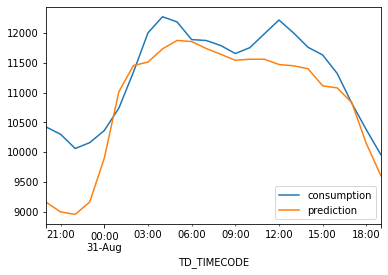

In [18]:
df_prediction.plot();

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>6. Conclusion</b>

<p style = 'font-size:16px;font-family:Arial'>This demonstration has illustrated a simplified - but complete - overview of how a typical machine learning workflow can be improved using Vantage in conjunction with open-source tools and techniques.  This combination allows users to leverage the innovation of open-source with the operational scale, power, and stability of Vantage.</p>

In [19]:
tdml.remove_context()

True

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2022 Teradata. All Rights Reserved</footer>